In [2]:
import os
import pandas as pd
import torch
import anndata as ad
from torch_geometric.loader import DataLoader
import scanpy as sc
from scregat.data_process import prepare_model_input,sum_counts,plot_edge, ATACGraphDataset
import numpy as np
from scregat.model import train_scregat, explain_model_ig
import pickle

In [13]:
import joblib
with open('./dataset_atac.pkl', 'rb') as f:
    dataset_atac = joblib.load(f)

In [29]:

dataset_graph = ATACGraphDataset('./input_graph/')

In [3]:
test_cell = pd.read_csv('./test_cell_name.txt')['x'].values

In [337]:
#import os
import pandas as pd
import torch
import anndata as ad
from torch_geometric.loader import DataLoader
import scanpy as sc
from scregat.data_process import prepare_model_input,sum_counts,plot_edge, ATACGraphDataset
import numpy as np
import pickle
import random
from tqdm import tqdm

seq_vec = torch.load('./seq.pth')

data = dataset_atac.array_peak
torch_vector = torch.zeros(len(data))
for idx, item in enumerate(data):
    if item.startswith('chr'):
        torch_vector[idx] = 0 
    else:
        torch_vector[idx] = 1 
train_graph = []
test_graph = []
test_cell_type = []
train_cell_type = []
for i, sample in tqdm(enumerate(dataset_graph), total=len(dataset_graph), desc='Processing samples'):

    seq_data = seq_vec
    sample.seq_data = seq_data
    sample.id_vec = torch_vector

    
    if sample.cell in test_cell:
        test_graph.append(sample)
        test_cell_type.append(sample.y.item())
    else:
        train_graph.append(sample)
        train_cell_type.append(sample.y.item())



Processing samples: 100%|██████████| 8821/8821 [00:01<00:00, 7779.77it/s]


In [853]:
import torch
import torch.nn as nn

class EdgeDiversityLoss1(nn.Module):
    def __init__(self, diversity_weight=1.0):
        """
        自定义多样性损失函数
        :param diversity_weight: 控制熵惩罚的权重
        """
        super(EdgeDiversityLoss1, self).__init__()
        self.diversity_weight = diversity_weight

    def forward(self, edge_weights):
        prob_distribution = torch.softmax(edge_weights, dim=0)
        entropy_loss = -self.diversity_weight * torch.sum(prob_distribution * torch.log(prob_distribution + 1e-6), dim=0)
        
        # 添加均匀性损失
        target_distribution = torch.full_like(prob_distribution, 1.0 / edge_weights.numel())
        uniformity_loss = torch.sum((prob_distribution - target_distribution) ** 2)

        # 总损失
        loss = torch.sum(entropy_loss) + uniformity_loss
        return loss


In [854]:
import torch
import torch.nn as nn

class EdgeDiversityLoss2(nn.Module):
    def __init__(self, non_zero_penalty_weight=1.0):
        """
        自定义多样性损失函数
        :param non_zero_penalty_weight: 控制非零惩罚的权重
        """
        super(EdgeDiversityLoss2, self).__init__()
        self.non_zero_penalty_weight = non_zero_penalty_weight

    def forward(self, edge_weights):
        """
        计算自定义多样性损失
        :param edge_weights: 模型生成的边权重矩阵 (torch.Tensor)，形状为 (batch_size, num_edges)
        :return: 计算出的多样性损失 (torch.Tensor)
        """
        # 筛选出非零元素
        non_zero_weights = edge_weights[edge_weights != 0]

        # 计算非零元素的方差并取负
        variance_loss = -torch.var(non_zero_weights)

        # 计算非零惩罚：惩罚零权重的数量
        non_zero_penalty = self.non_zero_penalty_weight * torch.sum((edge_weights == 0).float())

        # 总损失：使用负方差作为多样性损失和非零惩罚的组合
        loss = variance_loss + non_zero_penalty
        return loss


In [855]:
atten[1]

tensor([[0.0168, 0.0168, 0.0000,  ..., 0.0168, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0167,  ..., 0.0169, 0.0000, 0.0167],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0168, 0.0000],
        ...,
        [0.0168, 0.0000, 0.0168,  ..., 0.0000, 0.0168, 0.0169],
        [0.0168, 0.0000, 0.0168,  ..., 0.0000, 0.0168, 0.0000],
        [0.0000, 0.0168, 0.0168,  ..., 0.0168, 0.0168, 0.0169]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>)

In [856]:
atten[1].shape

torch.Size([285709, 16])

In [857]:
def drop_edges(edge_index, drop_rate=0.1):
    """随机丢弃边，依据设定的丢弃比例。
    Args:
        edge_index (torch.Tensor): 边的张量，形状为 (2, num_edges)。
        drop_rate (float): 要丢弃的边的比例。
    Returns:
        torch.Tensor: 丢弃部分边后的 edge_index。
    """
    num_edges = edge_index.size(1)
    mask = torch.rand(num_edges) > drop_rate
    return edge_index[:, mask]

In [858]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class SCReGAT(torch.nn.Module):
    def __init__(self,
                 node_input_dim=2,
                 node_output_dim=8,
                 edge_embedding_dim=8,
                 hidden_channels=16,  # 增加 hidden_channels
                 gat_input_channels=8,
                 gat_hidden_channels=8,  # 增加 GAT 隐藏通道
                 seq_dim=768,
                 seq2node_dim=1,
                 max_tokens=1024,
                 dropout=0.4,  # 增加 dropout
                 num_head_1=16,  # 增加 GAT 头数
                 num_head_2=16):  # 增加 GAT 头数
        super(SCReGAT, self).__init__()

        # Sequence transformation layer (currently commented out in forward)
        self.NN_seq = nn.Sequential(
            nn.Linear(seq_dim, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(),
            nn.Linear(512, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(),
            nn.Linear(128, seq2node_dim),
        )

        # Node feature transformation with BatchNorm
        self.NN_node = nn.Sequential(
            nn.Linear(node_input_dim, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(),
            nn.Linear(64, node_output_dim),
        )

        # Edge feature transformation with BatchNorm
        self.NN_edge = nn.Sequential(
            nn.Linear(3, 16),
            nn.LayerNorm(16),
            nn.LeakyReLU(),
            nn.Linear(16, edge_embedding_dim),
            nn.LeakyReLU()
        )

        # GAT layers with increased heads and self-loops
        self.NN_conv1 = GATConv(node_output_dim, hidden_channels, heads=num_head_1, dropout=dropout, edge_dim=edge_embedding_dim, add_self_loops=False)
        self.NN_flatten1 = nn.Linear(num_head_1 * hidden_channels, hidden_channels)

        self.NN_conv2 = GATConv(hidden_channels, hidden_channels, heads=num_head_2, dropout=dropout, add_self_loops=False)
        self.NN_flatten2 = nn.Linear(num_head_2 * hidden_channels, hidden_channels)

        self.dropout = nn.Dropout(0.1)  
        self.relu = nn.ReLU()
        self.leaky = nn.LeakyReLU()
        
        self.NN_cell_type = nn.Sequential(
            nn.Linear(1882, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(),
            nn.Linear(64, 9),
            nn.Softmax()
        )
        

    def forward(self, seq_data, raw_x, edge_index, edge_tf, batch, gene_num, gene_id_vec, is_test=False):
        data = raw_x
        seq_data = self.NN_seq(seq_data)
        data = torch.cat((data, seq_data), dim=1)
        data = self.NN_node(data)
         
        hidden_edge_input = torch.cat((raw_x[edge_index[0]] * raw_x[edge_index[1]], raw_x[edge_index[0]], raw_x[edge_index[1]]), dim=1)
        hidden_edge = self.NN_edge(hidden_edge_input).sigmoid()
        
        model.edge = torch.median(hidden_edge, dim=1)[0]
        data, atten_w1 = self.NN_conv1(data, edge_index, edge_attr=hidden_edge, return_attention_weights=True)
        data_1 = self.leaky(self.NN_flatten1(data))

        data_2, atten_w2 = self.NN_conv2(data_1, edge_tf, return_attention_weights=True)
        data_2 = self.leaky(self.NN_flatten2(data_2))
        
        data = data_1 + data_2
        self.data = data
        if is_test == False:
            cell_type = self.NN_cell_type(torch.mean(data[gene_id_vec==1], dim=1))
        else:
            cell_type = None
            pass
        gene_out = -F.log_softmax(data[gene_id_vec==1], dim=1)[:, 0]

        return gene_out, atten_w1, cell_type

import torch
import torch.nn as nn

In [859]:
sample.y_exp.shape

torch.Size([1882])

In [860]:
def get_split(mt, batch_size):
    edge_flattened = mt
    if edge_flattened.size(0) % batch_size == 0:
        split_edges = edge_flattened.split(edge_flattened.size(0) // batch_size)
    else:
        remainder = edge_flattened.size(0) % batch_size
        edge_flattened = edge_flattened[:-remainder]  # Drop the remainder
        split_edges = edge_flattened.split(edge_flattened.size(0) // batch_size)
    return torch.vstack(split_edges)

In [861]:
len(dataset_atac.array_celltype)

9

In [871]:
model = SCReGAT()

In [873]:
c

Epoch 1/20:   1%|          | 1/100 [00:00<00:23,  4.14batch/s, attention_loss=1.83, cell_loss=2.25, loss=4.21, loss1=0.00478, sparse_loss=0.123]

tensor([9.0833e-05, 2.0156e-04, 2.6378e-04,  ..., 9.6334e-04, 6.9892e-04,
        6.1860e-02], device='cuda:0', grad_fn=<NegBackward0>) tensor([0.3951, 0.3951, 0.3951,  ..., 0.3951, 0.3951, 0.3951], device='cuda:0',
       grad_fn=<MedianBackward1>) (tensor([[  1900,   1901,   1902,  ..., 206124, 206132, 206134],
        [     0,      0,      0,  ...,   1881,   1881,   1881]],
       device='cuda:0'), tensor([[0.0136, 0.0000, 0.0168,  ..., 0.0000, 0.0000, 0.0161],
        [0.0000, 0.0164, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0168,  ..., 0.0163, 0.0163, 0.0000],
        ...,
        [0.0000, 0.0163, 0.0167,  ..., 0.0000, 0.0161, 0.0000],
        [0.0130, 0.0163, 0.0000,  ..., 0.0162, 0.0000, 0.0159],
        [0.0000, 0.0163, 0.0168,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([9.0833e-05, 2.0156e-04, 2.6378e-04,  ..., 9.6334e-04, 6.9892e-04,
        6.1860e-02], device='cuda:0', grad_fn=<NegBack

Epoch 1/20: 100%|██████████| 100/100 [00:28<00:00,  3.48batch/s, attention_loss=1.83, cell_loss=2.19, loss=4.15, loss1=0.0047, sparse_loss=0.123]


Epoch [1/20], Average Loss: 4.1480, Loss1: 0.0047, Attention Loss: 1.8284, Sparse Loss: 0.1228, Cell Loss: 2.1921


Epoch 2/20:   1%|          | 1/100 [00:00<00:29,  3.38batch/s, attention_loss=1.83, cell_loss=2.19, loss=4.14, loss1=0.00489, sparse_loss=0.123]

tensor([1.1921e-07, 8.0344e-05, 2.8610e-06,  ..., 1.1921e-07, 2.4557e-05,
        6.4206e-03], device='cuda:0', grad_fn=<NegBackward0>) tensor([0.3824, 0.3824, 0.3824,  ..., 0.3882, 0.3882, 0.3882], device='cuda:0',
       grad_fn=<MedianBackward1>) (tensor([[  1900,   1901,   1902,  ..., 206124, 206132, 206134],
        [     0,      0,      0,  ...,   1881,   1881,   1881]],
       device='cuda:0'), tensor([[1.5962e-03, 0.0000e+00, 2.5864e-03,  ..., 0.0000e+00, 6.8169e-03,
         4.9254e-03],
        [0.0000e+00, 6.7597e-03, 2.5713e-03,  ..., 6.9037e-03, 6.7946e-03,
         4.9038e-03],
        [0.0000e+00, 6.7546e-03, 2.5677e-03,  ..., 6.8935e-03, 0.0000e+00,
         0.0000e+00],
        ...,
        [6.6939e-05, 0.0000e+00, 0.0000e+00,  ..., 6.9297e-03, 6.8277e-03,
         0.0000e+00],
        [6.6924e-05, 6.7659e-03, 0.0000e+00,  ..., 6.9292e-03, 6.8273e-03,
         4.8372e-03],
        [6.6772e-05, 6.7635e-03, 2.3971e-03,  ..., 6.9211e-03, 6.8236e-03,
         4.8325e-03]],

Epoch 2/20: 100%|██████████| 100/100 [00:28<00:00,  3.49batch/s, attention_loss=1.83, cell_loss=2.18, loss=4.14, loss1=0.0047, sparse_loss=0.123]


Epoch [2/20], Average Loss: 4.1393, Loss1: 0.0047, Attention Loss: 1.8285, Sparse Loss: 0.1228, Cell Loss: 2.1833


Epoch 3/20:   1%|          | 1/100 [00:00<00:28,  3.53batch/s, attention_loss=1.83, cell_loss=2.24, loss=4.2, loss1=0.00455, sparse_loss=0.123]

tensor([9.0714e-05, 2.4947e-04, 1.1921e-07,  ..., 4.0531e-06, 3.7550e-05,
        2.4482e-01], device='cuda:0', grad_fn=<NegBackward0>) tensor([0.3808, 0.3808, 0.3808,  ..., 1.0000, 0.3808, 0.3808], device='cuda:0',
       grad_fn=<MedianBackward1>) (tensor([[  1900,   1901,   1902,  ..., 206124, 206132, 206134],
        [     0,      0,      0,  ...,   1881,   1881,   1881]],
       device='cuda:0'), tensor([[0.0014, 0.0000, 0.0030,  ..., 0.0068, 0.0063, 0.0048],
        [0.0014, 0.0000, 0.0029,  ..., 0.0000, 0.0000, 0.0047],
        [0.0000, 0.0000, 0.0028,  ..., 0.0000, 0.0000, 0.0047],
        ...,
        [0.0537, 0.0496, 0.0507,  ..., 0.0000, 0.0507, 0.0530],
        [0.0000, 0.0000, 0.0029,  ..., 0.0066, 0.0000, 0.0000],
        [0.0014, 0.0000, 0.0029,  ..., 0.0066, 0.0000, 0.0047]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>))
gene_pre: tensor([9.0714e-05, 2.4947e-04, 1.1921e-07,  ..., 4.0531e-06, 3.7550e-05,
        2.4482e-01], device='cuda:0', grad_fn=<NegBack

Epoch 3/20:  69%|██████▉   | 69/100 [00:19<00:08,  3.50batch/s, attention_loss=1.83, cell_loss=2.18, loss=4.13, loss1=0.0047, sparse_loss=0.123] 


KeyboardInterrupt: 

In [874]:
import torch
from tqdm import tqdm

batch_size = 4
test_loader = DataLoader(test_graph, batch_size=batch_size, shuffle=True, pin_memory=True)
model.eval()
device = 'cuda:3'
model.to(device)

cell_type = []
test_barcodes = []
cell_link_atten = []
cell_link_activity = []
cell_link_edge = []
cell_link_enhancer = []

with torch.no_grad():
    for idx, sample in tqdm(enumerate(test_loader), total=len(test_loader), desc="Processing Batches"):
        gene_num = sample.y_exp.shape[0]
        gene_pre, atten, _ = model(
            sample.seq_data.to(device),
            sample.x.to(device), 
            sample.edge_index.to(device), 
            sample.edge_tf.T.to(device), 
            sample.batch.to(device), 
            gene_num, 
            sample.id_vec.to(device), 
            is_test=True
        )
        sample_size = len(sample.y)
        test_barcodes.extend(sample.cell)  # Ensure on CPU
        cell_type.extend(sample.y.cpu().numpy())

        # Edge processing
        edge_temp = model.edge.flatten().to('cpu')
        edge_lists = edge_temp.split(edge_temp.size(0) // sample_size)

        for edge in edge_lists:
            min_val = edge.min()
            max_val = edge.max()
            normalized_edge = (edge - min_val) / (max_val - min_val + 1e-10)  # Prevent division by zero
            cell_link_edge.append(normalized_edge)

        # Flatten and process attention data
        atten_x_indices = atten[0][1].cpu()
        atten_enhancer_indices = atten[0][0].cpu()
        flattened_sample_x = sample.x[atten_x_indices].flatten().to('cpu')
        flattened_sample_enhancer = sample.x[atten_enhancer_indices].flatten().to('cpu')
        atten1_max = atten[1].mean(dim=1).to('cpu')

        # Split and collect
        for x, enhancer, atten_ in zip(
            flattened_sample_x.split(flattened_sample_x.size(0) // sample_size),
            flattened_sample_enhancer.split(flattened_sample_enhancer.size(0) // sample_size),
            atten1_max.split(atten1_max.size(0) // sample_size)
        ):
            cell_link_activity.append(x)
            cell_link_atten.append(atten_)
            cell_link_enhancer.append(enhancer)

        # Clear cache
        torch.cuda.empty_cache()

# Optionally return or further process the collected data


Processing Batches: 100%|██████████| 883/883 [15:11<00:00,  1.03s/it]


In [ ]:
cell_link_atten = torch.stack(cell_link_atten)
cell_link_edge = torch.stack(cell_link_edge)
cell_link_activity = torch.stack(cell_link_activity)
cell_link_enhancer = torch.stack(cell_link_enhancer)

In [877]:
import torch




torch.save({
    'model_state_dict': model.state_dict(),
    'cell_link_atten': cell_link_atten,
    'cell_link_edge': cell_link_edge,
    'cell_link_activity': cell_link_activity,
    'cell_link_enhancer': cell_link_enhancer
}, 'model_and_data.pt')

print("模型和数据已保存为 model_and_data.pt")


模型和数据已保存为 model_and_data.pt


In [ ]:
torch.sum(cell_link_atten[0] == 0)

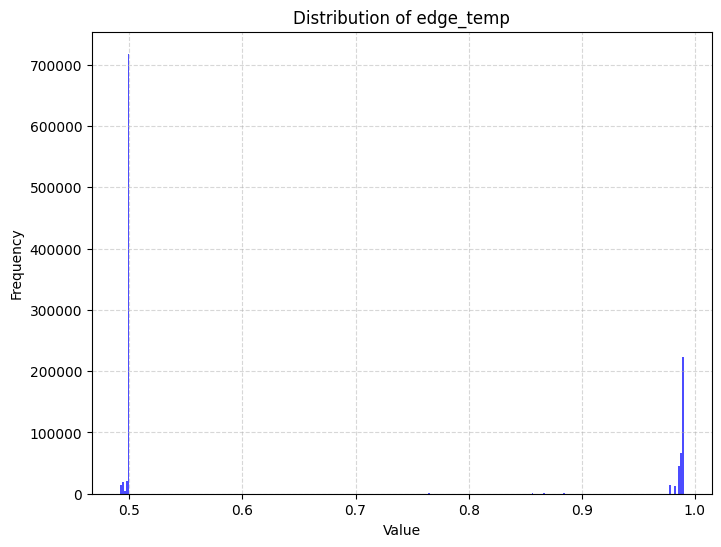

In [805]:
import torch
import matplotlib.pyplot as plt


# 将 tensor 转换为 numpy 数组以用于绘图
# edge_temp_np = atten[1][:, 0].cpu().detach().numpy()
edge_temp_np = model.edge.cpu().detach().numpy()

# 绘制分布图
plt.figure(figsize=(8, 6))
plt.hist(edge_temp_np, bins=300, alpha=0.7, color='blue')
plt.title('Distribution of edge_temp')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [767]:
atten.shape

torch.Size([285709])

In [425]:
cell_link_enhancer = torch.stack(cell_link_enhancer)

In [806]:
cell_link_atten = torch.stack(cell_link_atten)
cell_link_edge = torch.stack(cell_link_edge)
cell_link_activity = torch.stack(cell_link_activity)
cell_link_enhancer = torch.stack(cell_link_enhancer)

In [835]:
 cell_link_edge.cpu().numpy()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [834]:
import numpy as np

# Assuming cell_link_edge is a torch tensor
data_np = cell_link_edge.cpu().numpy()

# Set values < 0.6 to 0
data_np[data_np < 0.5] = 0

print(data_np)


import numpy as np
adata_edge = ad.AnnData(
    X=data_np, obs=dataset_atac.adata.obs.loc[test_barcodes])
adata = adata_edge
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat')
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=20)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=['celltype'], wspace=0.4,frameon=False)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


IndexError: index -1 is out of bounds for axis 0 with size 0

In [816]:
cell_link_enhancer.cpu().numpy()

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        1.7569476],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.9313355],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [ ]:
dataset_atac.adata.obs

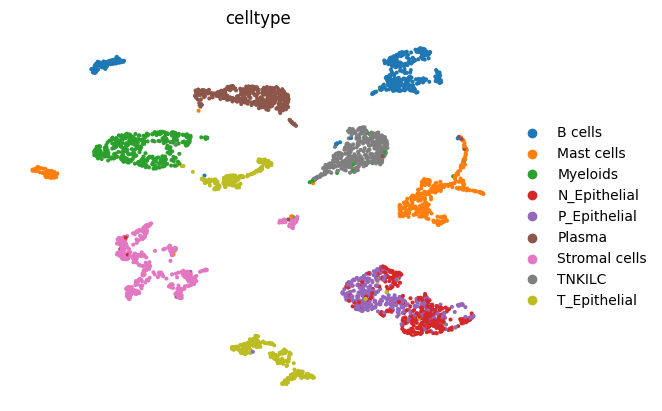

In [881]:
data_np = cell.cpu().numpy() 
import numpy as np
adata_edge = ad.AnnData(
    X=data_np, obs=dataset_atac.adata.obs.loc[test_barcodes])
adata = adata_edge
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat')
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=20)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=['celltype'], wspace=0.4,frameon=False)

In [15]:
cell_link_atten = data['cell_link_atten']

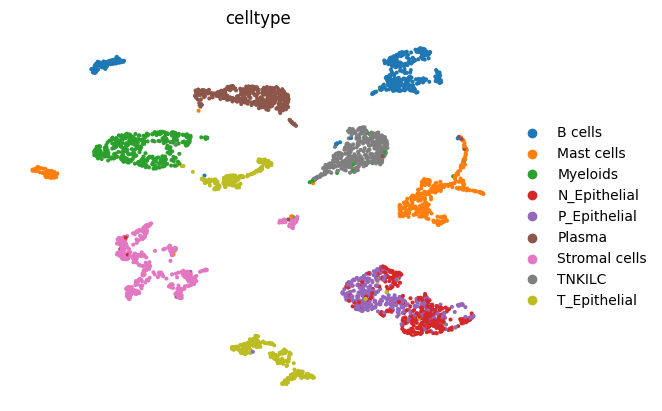

In [16]:
data_np = cell_link_atten.cpu().numpy()

import numpy as np
adata_edge = ad.AnnData(
    X=data_np, obs=dataset_atac.adata.obs.loc[test_barcodes])
adata = adata_edge
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat')
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=20)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=['celltype'], wspace=0.4,frameon=False)

In [802]:

import numpy as np


data_np = cell_link_atten.cpu().numpy()
import numpy as np
adata_edge = ad.AnnData(
    X=combined, obs=dataset_atac.adata.obs.loc[test_barcodes])
adata = adata_edge
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat')
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=20)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=['celltype'], wspace=0.4,frameon=False)

ValueError: Observations annot. `obs` must have number of rows of `X` (448), but has 280 rows.

In [3]:
data = torch.load('./model_and_data.pt')

In [5]:
cell_link_edge = data['cell_link_edge']

In [11]:
test_barcodes = pd.read_csv('./edge_ris_row.csv')['0'].values

In [12]:
data_np = cell_link_edge.cpu().numpy()

import numpy as np
adata_edge = ad.AnnData(
    X=data_np, obs=dataset_atac.adata.obs.loc[test_barcodes])
adata = adata_edge
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat')
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=20)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=['celltype'], wspace=0.4,frameon=False)

NameError: name 'dataset_atac' is not defined

In [189]:
torch.max(cell_link_edge[0])

tensor(0.)

In [125]:
torch.save(cell_link_enhancer, 'cell_link_enhancer.pt')

In [123]:
torch.save(cell_link_atten, 'cell_link_atten.pt')

In [7]:
import pandas as pd

In [24]:
atten = [[]]

In [25]:
 atten[0] =dataset_graph[0].edge_index

In [18]:
cpc_loop_df = pd.read_csv('./CPC_loops_overlap.csv', index_col=0)

In [19]:
insoveled_genes = pd.read_csv('./select_gene.txt')

In [20]:
insoveled_genes = insoveled_genes[insoveled_genes['cluster']  == 'T_Epithelial']['gene'].values

In [21]:
cpc_loop_df = cpc_loop_df[cpc_loop_df['Interaction Gene'].isin(insoveled_genes)]

In [22]:
cpc_loop_df['Gene_Chrom_Start_End'].values

array(['KIF1B-chr1-10398082-10398582', 'KIF1B-chr1-10398711-10399211',
       'KIF1B-chr1-10399311-10399811', ...,
       'RNF128-chrX-106042332-106042832',
       'GABRE-chrX-151359989-151360489',
       'BCAP31-chrX-153539405-153539905'], dtype=object)

In [23]:
temp_df = pd.read_csv('../test_fast//intersect_CRC_cellline_link.txt')

# Define a function to clean up the gene and chromosome location
def clean_location(entry):
    # Remove any unwanted characters
    return entry.strip("')")

# Clean the index and data
temp_df['Gene'] = temp_df.index.str.strip("('")
temp_df['Location'] = temp_df['x'].apply(clean_location)

# Drop the original 'x' column
temp_df = temp_df.drop(columns=['x'])

# Display the cleaned DataFrame
print(temp_df.head())
gene_list = [t.split('\'')[-1] for t in temp_df['Gene'].values]
peak_list = [t.split('\'')[0] for t in temp_df['Location'].values]
df = pd.DataFrame({'gene':gene_list, 'peak':peak_list})
df.head()

                   Gene                     Location
1 "('A2M'      1 "('A2M     chr12-8709390-8709890')"
2 "('A2M'      2 "('A2M     chr12-8709390-8709890')"
3 "('ABCA1'  3 "('ABCA1  chr9-107918652-107919152')"
4 "('ABCA1'  4 "('ABCA1  chr9-107929677-107930177')"
5 "('ABCA1'  5 "('ABCA1  chr9-107999805-108000305')"


,gene,peak
0,A2M,chr12-8709390-8709890
1,A2M,chr12-8709390-8709890
2,ABCA1,chr9-107918652-107919152
3,ABCA1,chr9-107929677-107930177
4,ABCA1,chr9-107999805-108000305


In [28]:
pd.read_csv('./edge_ris_colume.csv')['0'].values

0            ('CCNL2','chr1-1397443-1397943')
1            ('CCNL2','chr1-1398100-1398600')
2            ('CCNL2','chr1-1398689-1399189')
3            ('CCNL2','chr1-1399250-1399750')
4            ('CCNL2','chr1-1399890-1400390')
                         ...                 
285704    ('FLNA','chrX-154444467-154444967')
285705    ('FLNA','chrX-154458500-154459000')
285706    ('FLNA','chrX-154459708-154460208')
285707    ('FLNA','chrX-154485387-154485887')
285708    ('FLNA','chrX-154486493-154486993')
Name: 0, Length: 285709, dtype: object

In [25]:
dataset_atac[0]

TypeError: 'ATACDataset' object is not subscriptable

In [34]:
atten = [[]]

atten[0] = dataset_graph[0].edge_index

In [35]:
pos_dict = dict()
pos_dict_int = dict()
for idx, t in enumerate(dataset_atac.array_peak):
    pos_dict[t] = idx
    pos_dict_int[idx] = t
    
str_lists = []
for t in range(atten[0].shape[1]):
    str_lists.append(pos_dict_int[atten[0][1][t].item()] +  '-'  + pos_dict_int[atten[0][0][t].item()]) 

In [33]:
atten

tensor([[  1900,   1901,   1902,  ..., 206124, 206132, 206134],
        [     0,      0,      0,  ...,   1881,   1881,   1881]])

In [36]:
target_links = []
for t in df.values:
    target_links.append(t[0] + '-' + t[1])

In [37]:
from tqdm import tqdm

# Create a mapping of each string to its index
str_lists_index = {s: i for i, s in enumerate(str_lists)}

map_index = []
for t in tqdm(cpc_loop_df['Gene_Chrom_Start_End'].values, desc="Processing"):
    if t in str_lists_index:
        map_index.append(str_lists_index[t])


Processing: 100%|██████████| 8275/8275 [00:00<00:00, 381614.79it/s]


In [53]:
t1 = dataset_atac.array_peak[atten[0][0].cpu().numpy()]
t2 = dataset_atac.array_peak[atten[0][1].cpu().numpy()]

colnames = []
for i in range(len(t1)):
    colnames.append("(" + '\'' + t2[i] + '\'' + ',' + '\'' + t1[i] + '\'' + ")")

In [59]:
np.array(colnames)[np.array(map_index)]

array(["('KIF1B','chr1-10398082-10398582')",
       "('KIF1B','chr1-10398711-10399211')",
       "('KIF1B','chr1-10399311-10399811')", ...,
       "('RNF128','chrX-106042332-106042832')",
       "('GABRE','chrX-151359989-151360489')",
       "('BCAP31','chrX-153539405-153539905')"], dtype='<U40')

In [62]:
cell_link_edge.size()

torch.Size([3529, 285709])

In [60]:
pd.DataFrame(map_index).to_csv

,0
0,27132
1,27133
2,27134
3,27135
4,27136
...,...
8199,239807
8200,239807
8201,239808
8202,240396


In [917]:
edge_df = pd.DataFrame(cell_link_edge)

In [2]:
import torch 

In [3]:
data = torch.load('model_and_data.pt')

In [4]:
data.keys()

dict_keys(['model_state_dict', 'cell_link_atten', 'cell_link_edge', 'cell_link_activity', 'cell_link_enhancer'])

In [32]:
cell_link_edge = data['cell_link_edge']

In [908]:
edge_df.columns = colnames

In [909]:
edge_df.index = test_barcodes

In [920]:
edge_df.to_csv('/remote-home/share/mdshare/temp/edge_ris.csv')

In [923]:
pd.DataFrame(colnames).to_csv('/remote-home/share/mdshare/temp/edge_ris_colume.csv')

In [925]:
pd.DataFrame(test_barcodes).to_csv('/remote-home/share/mdshare/temp/edge_ris_row.csv')

In [448]:
map_index = torch.tensor(map_index)

In [449]:
len(map_index)

8204

In [792]:
cell_type_cpu = dataset_atac.adata.obs.loc[test_barcodes]['celltype'].values

In [793]:
unique_celltype = np.unique(cell_type), np.unique(cell_type_cpu, return_counts=True)

In [794]:
unique_celltype = dataset_atac.array_celltype

In [760]:
cell_link_atten

tensor([[0.0033, 0.0033, 0.0018,  ..., 0.0038, 0.0038, 0.0065],
        [0.0028, 0.0028, 0.0028,  ..., 0.1360, 0.0031, 0.0031],
        [0.0034, 0.0034, 0.0162,  ..., 0.0034, 0.0034, 0.0014],
        ...,
        [0.0029, 0.0029, 0.0029,  ..., 0.0032, 0.0032, 0.0032],
        [0.0029, 0.0068, 0.0068,  ..., 0.0031, 0.0031, 0.0031],
        [0.0030, 0.0030, 0.0030,  ..., 0.0031, 0.0232, 0.0693]])

tensor([[  1900,   1901,   1902,  ..., 206124, 206132, 206134],
        [     0,      0,      0,  ...,   1881,   1881,   1881]])

In [787]:
import torch
from tqdm import tqdm
edge_index = sample.edge_index[:, :sample.edge_index.size(1)//4]
n_edge = edge_index.size(1)
edge_importance = cell_link_atten.clone()  
gene_degrees = torch.bincount(edge_index[1])  

In [788]:
edge_degree_groups = {}
for i in range(n_edge):
    gene_node = edge_index[1, i]
    degree = gene_degrees[gene_node]
    if degree.item() not in edge_degree_groups:
        edge_degree_groups[degree.item()] = []
    edge_degree_groups[degree.item()].append(i)

for degree, indices in tqdm(edge_degree_groups.items(), desc="Normalizing edges by gene degree"):
    values_tensor = edge_importance[:, indices] 
    min_val, max_val = values_tensor.min(dim=1, keepdim=True)[0], values_tensor.max(dim=1, keepdim=True)[0]
    normalized_values = (values_tensor - min_val) / (max_val - min_val + 1e-10) 
    edge_importance[:, indices] = normalized_values  

Normalizing edges by gene degree: 100%|██████████| 359/359 [00:00<00:00, 860.56it/s]


In [39]:
unique_celltype = dataset_atac.array_celltype

In [41]:
cell_type_cpu = pd.read_csv('/remote-home/share/mdshare/temp/edge_ris_row.csv')['0'].values

In [42]:
cell_type_cpu = dataset_atac.adata.obs.loc[cell_type_cpu]['celltype'].values

In [43]:
len(cell_type_cpu)

3529

In [44]:
cell_type_cpu

array(['A002-C-204-D#ACAAGCTTCATCGCTC-1',
       'A015-C-001-D#GGAACCCCATGCGTTA-1',
       'CRC-2-15564-D#GCTTTCGCACAGCCAC-1', ...,
       'A014-C-111-D#AGGCCTGGTATTCGCA-1',
       'A014-C-111-D#AGCGTGCGTGGAAGCT-1',
       'A002-C-106-D#TAATTCCCAGCGTGAA-1'], dtype=object)


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



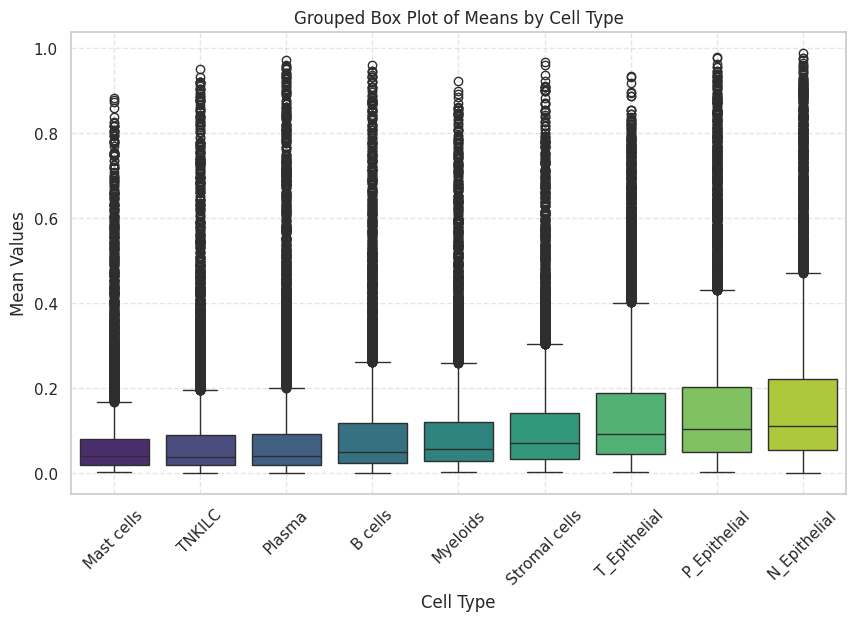

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 获取numpy数组
temp_normalized = cell_link_edge[:, map_index].cpu().numpy() 

# 计算每个细胞类型组的均值
means = [np.mean(temp_normalized[cell_type_cpu == unique_celltype[i], :], axis=0) for i in range(len(unique_celltype))]

# 创建数据框并按均值排序
mean_data = {'Group': ['Type ' + str(i) for i in range(len(unique_celltype))],
             'Mean': [np.mean(m) for m in means]}
mean_df = pd.DataFrame(mean_data).sort_values(by='Mean')

# 准备用于绘图的数据
sorted_means = [means[int(group.split(' ')[1])] for group in mean_df['Group']]
data = {'Group': np.repeat(mean_df['Group'], [len(m) for m in sorted_means]),
        'Values': np.concatenate(sorted_means)}
df = pd.DataFrame(data)
mean_df['Group'] = [unique_celltype[int(group.split(' ')[1])] for group in mean_df['Group']]

# 用更新的 Group 名字来替换 data 中的 Group
df['Group'] = [unique_celltype[int(group.split(' ')[1])] for group in df['Group']]

# 设置绘图风格
sns.set(style="whitegrid")  # 自然风格背景
palette = sns.color_palette("viridis", len(unique_celltype))  # 自然风格配色

# 创建箱线图
plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='Values', data=df, order=mean_df['Group'], palette=palette)
plt.title("Grouped Box Plot of Means by Cell Type")
plt.ylabel("Mean Values")
plt.xlabel("Cell Type")

# 设置 x 轴标签旋转
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [791]:
edge_importance.shape

torch.Size([280, 285709])

In [464]:
cell_link_atten[0] 

tensor([0.0077, 0.0077, 0.0077,  ..., 0.0081, 0.0081, 0.0081])

In [470]:
cpc_loop_df

,Chromosome,Start Site,End Site,Interaction Gene,Gene_Chrom_Start_End
302,chr1,10398082,10398582,KIF1B,KIF1B-chr1-10398082-10398582
307,chr1,10398711,10399211,KIF1B,KIF1B-chr1-10398711-10399211
312,chr1,10399311,10399811,KIF1B,KIF1B-chr1-10399311-10399811
316,chr1,10399821,10400321,KIF1B,KIF1B-chr1-10399821-10400321
320,chr1,10400499,10400999,KIF1B,KIF1B-chr1-10400499-10400999
...,...,...,...,...,...
246275,chrX,106039877,106040377,RNF128,RNF128-chrX-106039877-106040377
246278,chrX,106039877,106040377,RNF128,RNF128-chrX-106039877-106040377
246279,chrX,106042332,106042832,RNF128,RNF128-chrX-106042332-106042832
247104,chrX,151359989,151360489,GABRE,GABRE-chrX-151359989-151360489


In [457]:
dataset_atac.array_celltype

array(['B cells', 'Mast cells', 'Myeloids', 'N_Epithelial',
       'P_Epithelial', 'Plasma', 'Stromal cells', 'TNKILC',
       'T_Epithelial'], dtype=object)

In [371]:
atten

tensor([0.0101, 0.0101, 0.0101,  ..., 0.0101, 0.0101, 0.0101])

In [262]:
dataset_atac.array_celltype

array(['B cells', 'Mast cells', 'Myeloids', 'N_Epithelial',
       'P_Epithelial', 'Plasma', 'Stromal cells', 'TNKILC',
       'T_Epithelial'], dtype=object)

In [83]:
normalize_to_prob(model.data)

tensor([7.2317e-07, 6.8812e-07, 6.7725e-07,  ..., 4.8886e-06, 4.8886e-06,
        4.8886e-06], device='cuda:1', grad_fn=<DivBackward0>)

In [78]:
model.data

tensor([0.0252, 0.0240, 0.0236,  ..., 0.1704, 0.1704, 0.1704], device='cuda:1',
       grad_fn=<MeanBackward1>)

In [80]:
sample.y_exp

tensor([4.7479e-04, 1.0063e-03, 3.2451e-04,  ..., 1.2609e-05, 2.2495e-04,
        1.5094e-04])